In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchsummary import summary

import albumentations as album

In [2]:
#Defining train / val / test directories
DATA_DIR = 'Three_Phases_Segmentation/datasets/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

list = os.listdir(y_train_dir) # dir is your directory path
number_files = len(list)
print('len_train: ',number_files)

x_valid_dir = os.path.join(DATA_DIR, 'validation')
y_valid_dir = os.path.join(DATA_DIR, 'validation_labels')

list = os.listdir(y_valid_dir) # dir is your directory path
number_files = len(list)
print('len_valid: ',number_files)

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

list = os.listdir(y_test_dir) # dir is your directory path
number_files = len(list)
print('len: ',number_files)

len_train:  228
len_valid:  66
len:  66


In [3]:
#All dataset classes and their corresponding RGB values in labels
class_dict = pd.read_csv("Three_Phases_Segmentation/label_class_dict.csv")
# Get class names
select_classes = class_dict['name'].tolist()
# Get class RGB values
select_class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', select_classes)
print('Class RGB values: ', select_class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['pore', 'grain', 'water', 'air-grain', 'air-water', 'grain-water']
Class RGB values:  [[255, 255, 255], [0, 0, 0], [255, 0, 0], [0, 0, 255], [0, 255, 0], [255, 255, 0]]


In [4]:
#Helper functions for one-hot encoding/decoding
# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [5]:
class BuildingsDataset(torch.utils.data.Dataset):

    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        
        self.lr_transform = transforms.Compose([transforms.ToTensor()])
                    
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        return self.lr_transform(image), self.lr_transform(mask)
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)
    
# Defining Augmentations
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=128, width=128, always_apply=True),
        album.OneOf([album.HorizontalFlip(p=1),
                     album.VerticalFlip(p=1),
                     album.RandomRotate90(p=1)], p=0.5)]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    test_transform = [
        album.RandomCrop(height=128, width=128, always_apply=True)]
    return album.Compose(test_transform)

In [6]:
# Get train and val dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation= get_training_augmentation(),
    class_rgb_values=select_class_rgb_values) 

print('len_train_dataset: ',len(train_dataset))

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation= get_validation_augmentation(), 
    class_rgb_values=select_class_rgb_values)

print('len_valid_dataset: ',len(valid_dataset))

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, drop_last=True)

len_train_dataset:  228
len_valid_dataset:  66


In [7]:
"""
#Model Definition
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out
    
model = UNet(num_classes=6)
"""

'\n#Model Definition\nclass UNet(nn.Module):\n    \n    def __init__(self, num_classes):\n        super(UNet, self).__init__()\n        self.num_classes = num_classes\n        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)\n        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)\n        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)\n        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)\n        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)\n        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)\n        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)\n        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)\n        self.middle = self.conv_block(in_channels=512, out_channels=1024)\n        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)\n        self.expans

In [8]:
class conv(nn.Sequential):
    def __init__(self, in_ch, out_ch):
        super().__init__() #super() method lets you access methods from a parent class from within a child class
        self.add_module("Conv_1", nn.Conv2d(in_ch, out_ch, kernel_size=3, padding='same'))
        self.add_module("BN_1", nn.BatchNorm2d(out_ch))
        self.add_module("RELU_1", nn.ReLU())
        
class conv_block(nn.Sequential):
    def __init__(self, in_ch, out_ch):
        super().__init__() #super() method lets you access methods from a parent class from within a child class
        self.add_module("Conv_1", nn.Conv2d(in_ch, out_ch, kernel_size=3, padding='same'))
        self.add_module("BN_1", nn.BatchNorm2d(out_ch))
        self.add_module("RELU_1", nn.ReLU())
        #2nd layer 
        self.add_module("Conv_2",nn.Conv2d(out_ch, out_ch, kernel_size=3, padding='same'))
        self.add_module("BN_2", nn.BatchNorm2d(out_ch))
        self.add_module("RELU_2", nn.ReLU())
        
class encoder_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv_x2 = conv_block(in_ch, out_ch)
        self.MaxPool = nn.MaxPool2d((1,2), stride=(1,2))
    def forward(self, x):
        x = self.conv_x2(x)
        p = self.MaxPool(x)
        return x, p
    
class decoder_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.convT = nn.ConvTranspose2d(in_ch, out_ch, (1,2), (1,2))
        self.conv_x2 = conv_block(out_ch*2, out_ch)
    def forward(self, x, skip_features):
        x = self.convT(x)
        x = torch.cat((x, skip_features), dim=1)
        x = self.conv_x2(x)
        return x
    
class Unet_3L(nn.Module):
    def __init__(self, in_ch=3):
        super().__init__()
        self.encod_1 = encoder_block(in_ch, 32)
        self.encod_2 = encoder_block(32, 64)
        self.encod_3 = encoder_block(64, 128)
        #self.encod_4 = encoder_block(128, 256)
        
        #self.encod_5 = encoder_block(256, 512)
        #self.conv = conv(512, 1024)     
        #self.decod_1 = decoder_block(1024, 512)
        
        self.conv = conv(128, 256)
        
        #self.decod_2 = decoder_block(512, 256)
        self.decod_3 = decoder_block(256, 128)
        self.decod_4 = decoder_block(128, 64)
        self.decod_5 = decoder_block(64, 32)
        
        self.convf = nn.Conv2d(32, 6, kernel_size=3, padding='same')      
    def forward(self, x):
        x1, p1 = self.encod_1(x)
        x2, p2 = self.encod_2(p1)
        x3, p3 = self.encod_3(p2)
    
        b1 = self.conv(p3)
        
        d1 = self.decod_3(b1, x3)
        d2 = self.decod_4(d1, x2)
        d3 = self.decod_5(d2, x1)
        
        xf = self.convf(d3)
        return xf
    
#Instantiate the model
model = Unet_3L()

In [19]:
# Set Hyperparams
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 100

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)
summary(model,(3,128,128))

# Load best pretrained models
load_pretrained_models = True
model_path = "Unet_Seg_best.pth"
if load_pretrained_models:
    model.load_state_dict(torch.load(model_path,map_location=DEVICE))

# define loss function
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=1e-6)])#, weight_decay=0.0015

Layer (type:depth-idx)                   Output Shape              Param #
├─encoder_block: 1-1                     [-1, 32, 128, 128]        --
|    └─conv_block: 2-1                   [-1, 32, 128, 128]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 128, 128]        896
|    |    └─BatchNorm2d: 3-2             [-1, 32, 128, 128]        64
|    |    └─ReLU: 3-3                    [-1, 32, 128, 128]        --
|    |    └─Conv2d: 3-4                  [-1, 32, 128, 128]        9,248
|    |    └─BatchNorm2d: 3-5             [-1, 32, 128, 128]        64
|    |    └─ReLU: 3-6                    [-1, 32, 128, 128]        --
|    └─MaxPool2d: 2-2                    [-1, 32, 128, 64]         --
├─encoder_block: 1-2                     [-1, 64, 128, 64]         --
|    └─conv_block: 2-3                   [-1, 64, 128, 64]         --
|    |    └─Conv2d: 3-7                  [-1, 64, 128, 64]         18,496
|    |    └─BatchNorm2d: 3-8             [-1, 64, 128, 64]         128
|    |

In [18]:
# Training 
val_min = 0.427#np.inf
if TRAINING:
    train_losses = []
    val_losses = []
    for epoch in range(EPOCHS):
        #train
        model.train()
        epoch_loss = 0
        for X, Y in train_loader:
            X, Y = X.to(DEVICE), Y.to(DEVICE)
            optimizer.zero_grad()
            Y_pred = model(X)
            loss = criterion(Y_pred, Y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss/len(train_loader))
        #eval
        model.eval()
        val_loss=0
        with torch.no_grad():
            for X, Y in valid_loader:
                X, Y = X.to(DEVICE), Y.to(DEVICE)
                Y_pred = model(X)
                loss = criterion(Y_pred, Y)
                val_loss += loss.item()
            val_losses.append(val_loss/len(valid_loader))
            if (epoch+1)%10 ==0:
                print('Epoch: {} \tTraining Loss: {:.5f}, \tValidation Loss: {:.5f}'.format(epoch+1, epoch_loss/len(train_loader), val_loss/len(valid_loader)))
        
        if val_loss/len(valid_loader) < val_min:
            torch.save(model.state_dict(), "Unet_Seg_best.pth")
            val_min = val_loss/len(valid_loader)

Epoch: 10 	Training Loss: 0.43215, 	Validation Loss: 0.42797
Epoch: 20 	Training Loss: 0.42782, 	Validation Loss: 0.43388
Epoch: 30 	Training Loss: 0.42483, 	Validation Loss: 0.43226
Epoch: 40 	Training Loss: 0.42961, 	Validation Loss: 0.43302
Epoch: 50 	Training Loss: 0.42774, 	Validation Loss: 0.42293
Epoch: 60 	Training Loss: 0.42823, 	Validation Loss: 0.43823
Epoch: 70 	Training Loss: 0.41680, 	Validation Loss: 0.43155
Epoch: 80 	Training Loss: 0.43236, 	Validation Loss: 0.43967
Epoch: 90 	Training Loss: 0.42599, 	Validation Loss: 0.42620
Epoch: 100 	Training Loss: 0.44480, 	Validation Loss: 0.43790


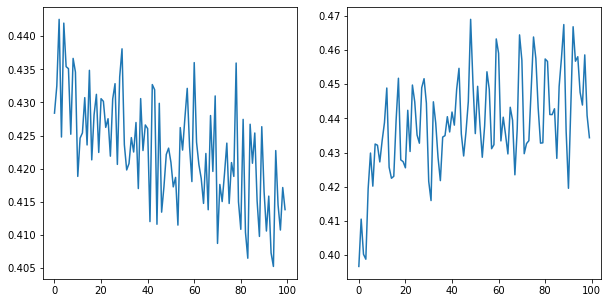

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(train_losses)
axes[1].plot(val_losses)

In [12]:
test_dataset = BuildingsDataset(
    x_test_dir, y_test_dir, 
    augmentation= get_validation_augmentation(), 
    class_rgb_values=select_class_rgb_values)

print('len_test_dataset: ',len(test_dataset))

# Get test loaders
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

len_test_dataset:  66


Original Images
GT Images
Output Images


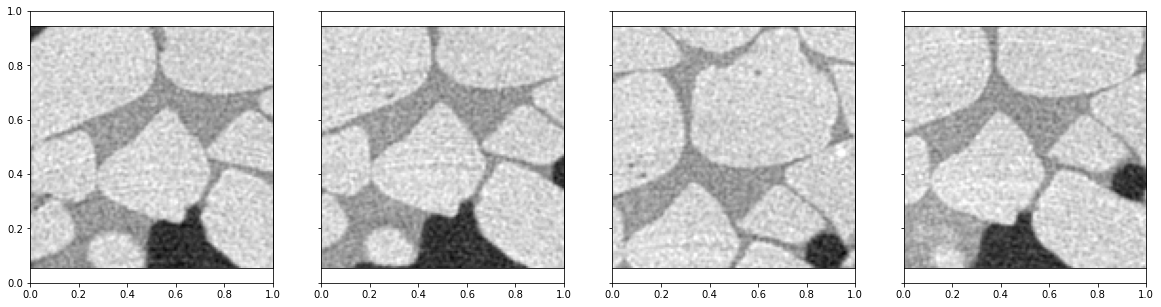

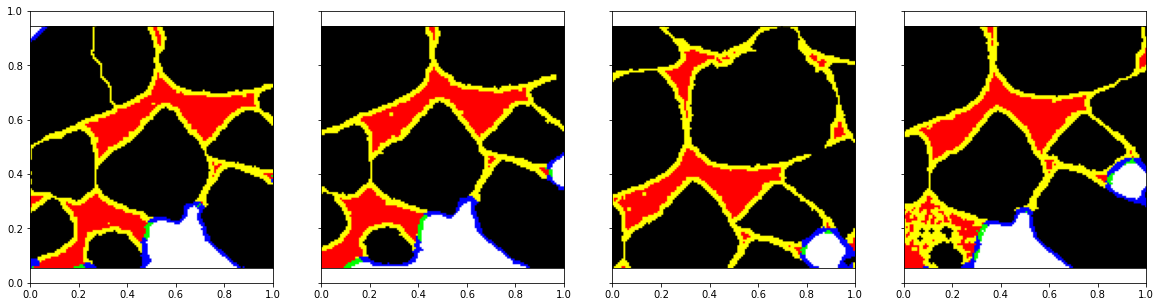

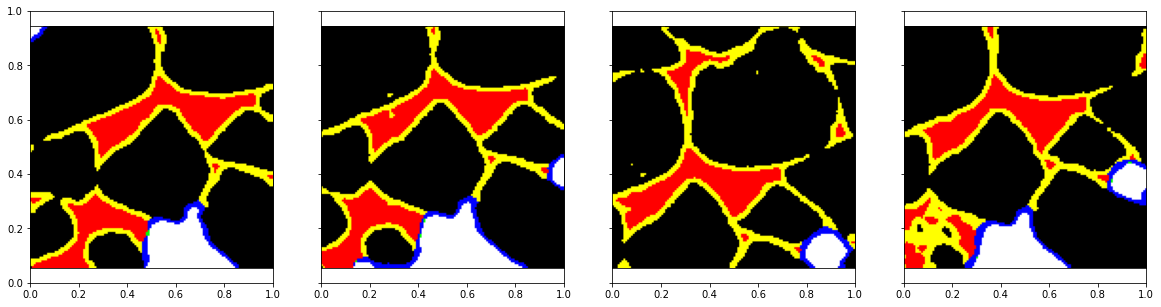

In [20]:
#Batch of train images
dataiter = iter(test_loader)
imgs = dataiter.next()
images, GT = imgs
        
model.eval()
with torch.no_grad():
    #Sample outputs
    output = model(images.to(DEVICE))

    output = output.cpu()
    output = output.view(16, 6, 128, 128)
    output = output.detach().numpy()

    #Original Images
    print("Original Images")
    fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(20,5))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        ax.imshow(np.transpose(np.squeeze(images.cpu().detach().numpy()[idx]),(1, 2, 0)))
        
    #GT Images
    print("GT Images")
    fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(20,5))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        ax.imshow(colour_code_segmentation(reverse_one_hot(np.transpose(np.squeeze(GT.cpu().detach().numpy()[idx]),(1, 2, 0))),select_class_rgb_values))

    #OutputImages
    print("Output Images")
    fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(20,5))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        ax.imshow(colour_code_segmentation(reverse_one_hot(np.transpose(np.squeeze(output[idx]),(1, 2, 0))),select_class_rgb_values))